In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = 'archiveFaces/face_age'
output_dir = 'archiveFaces/output'

train_menor_dir = os.path.join(output_dir, 'train', 'menor_de_edad')
val_menor_dir = os.path.join(output_dir, 'val', 'menor_de_edad')
train_mayor_dir = os.path.join(output_dir, 'train', 'mayor_de_edad')
val_mayor_dir = os.path.join(output_dir, 'val', 'mayor_de_edad')
os.makedirs(train_menor_dir, exist_ok=True)
os.makedirs(val_menor_dir, exist_ok=True)
os.makedirs(train_mayor_dir, exist_ok=True)
os.makedirs(val_mayor_dir, exist_ok=True)


def split_and_copy_files(src_dir, train_dir, val_dir, split_ratio=0.2):
    all_files = [os.path.join(src_dir, f) for f in os.listdir(
        src_dir) if os.path.isfile(os.path.join(src_dir, f))]

    if len(all_files) > 1:
        train_files, val_files = train_test_split(
            all_files, test_size=split_ratio, random_state=42)
    else:
        train_files = all_files
        val_files = []

    for file in train_files:
        shutil.copy(file, train_dir)

    for file in val_files:
        shutil.copy(file, val_dir)


for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        age = int(folder)

        if age < 18:
            split_and_copy_files(folder_path, train_menor_dir, val_menor_dir)
        else:
            split_and_copy_files(folder_path, train_mayor_dir, val_mayor_dir)

print("Clasificación y división completadas.")

Clasificación y división completadas.


In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall  # Importar las métricas

# Configuración
img_height = 200
img_width = 200
num_classes = 1  # Clasificación binaria

def set_seed(seed=5):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(8)

# Función para crear el modelo
def create_model(learning_rate, use_batch_norm):
    inputs = Input(shape=(img_height, img_width, 3))
    x = inputs

    # 1er bloque convolucional
    for filters in [32, 64, 128, 256]:
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

    # GlobalAveragePooling
    x = GlobalAveragePooling2D()(x)

    # Capa densa oculta
    x = Dense(32, activation='relu')(x)
    if use_batch_norm:
        x = BatchNormalization()(x)

    # Capa de salida
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # Crear modelo
    model = Model(inputs=inputs, outputs=outputs)

    # Compilar modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    return model

# Directorios de datos
train_dir = 'archiveFaces/output/train'
val_dir = 'archiveFaces/output/val'

# Generadores de datos con aumento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar los píxeles al rango [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Normalizar los píxeles al rango [0, 1]

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

# Parámetros para probar
learning_rates = [0.01, 0.001, 0.0005, 0.0001]
batch_sizes = [16, 32, 64]
batch_norm_options = [True, False]

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Entrenamiento de los modelos
for lr in learning_rates:
    for batch_size in batch_sizes:
        for use_batch_norm in batch_norm_options:
            model_name = f"model_lr_{lr}_batch_{batch_size}_batchnorm_{use_batch_norm}"
            model_path = f"{model_name}.h5"
            history_path = f"{model_name}_history.npy"

            if os.path.exists(model_path) and os.path.exists(history_path):
                print(f"{model_name} ya existe. Saltando entrenamiento.")
                continue

            print(f"Entrenando {model_name}...")

            model = create_model(lr, use_batch_norm)
            train_generator.batch_size = batch_size
            val_generator.batch_size = batch_size

            history = model.fit(
                train_generator,
                epochs=150,  # Aumenta el número de épocas si es necesario
                validation_data=val_generator,
                callbacks=[early_stopping, reduce_lr]
            )

            # Guardar el modelo entrenado
            model.save(model_path)

            # Guardar el historial de entrenamiento
            np.save(history_path, history.history)

            print(f"{model_name} entrenado y guardado.")

print("Entrenamiento completado.")

Found 7780 images belonging to 2 classes.
Found 1998 images belonging to 2 classes.
model_lr_0.01_batch_16_batchnorm_True ya existe. Saltando entrenamiento.
model_lr_0.01_batch_16_batchnorm_False ya existe. Saltando entrenamiento.
model_lr_0.01_batch_32_batchnorm_True ya existe. Saltando entrenamiento.
model_lr_0.01_batch_32_batchnorm_False ya existe. Saltando entrenamiento.
model_lr_0.01_batch_64_batchnorm_True ya existe. Saltando entrenamiento.
model_lr_0.01_batch_64_batchnorm_False ya existe. Saltando entrenamiento.
model_lr_0.001_batch_16_batchnorm_True ya existe. Saltando entrenamiento.
model_lr_0.001_batch_16_batchnorm_False ya existe. Saltando entrenamiento.
model_lr_0.001_batch_32_batchnorm_True ya existe. Saltando entrenamiento.
model_lr_0.001_batch_32_batchnorm_False ya existe. Saltando entrenamiento.
model_lr_0.001_batch_64_batchnorm_True ya existe. Saltando entrenamiento.
model_lr_0.001_batch_64_batchnorm_False ya existe. Saltando entrenamiento.
model_lr_0.0005_batch_16_bat

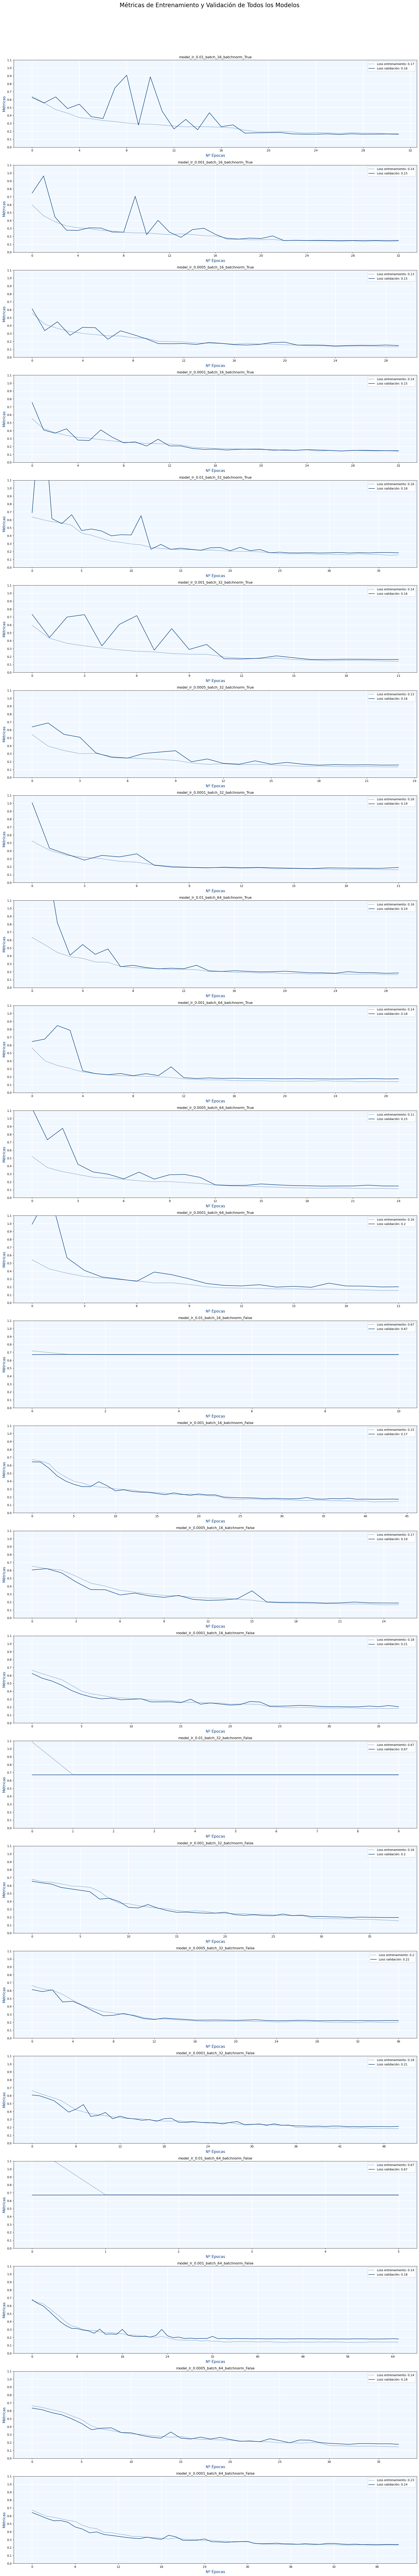

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator

# Lista de nombres de los modelos entrenados
model_names = [
    "model_lr_0.01_batch_16_batchnorm_True",
    "model_lr_0.001_batch_16_batchnorm_True",
    "model_lr_0.0005_batch_16_batchnorm_True",
    "model_lr_0.0001_batch_16_batchnorm_True",
    "model_lr_0.01_batch_32_batchnorm_True",
    "model_lr_0.001_batch_32_batchnorm_True",
    "model_lr_0.0005_batch_32_batchnorm_True",
    "model_lr_0.0001_batch_32_batchnorm_True",
    "model_lr_0.01_batch_64_batchnorm_True",
    "model_lr_0.001_batch_64_batchnorm_True",
    "model_lr_0.0005_batch_64_batchnorm_True",
    "model_lr_0.0001_batch_64_batchnorm_True",
    "model_lr_0.01_batch_16_batchnorm_False",
    "model_lr_0.001_batch_16_batchnorm_False",
    "model_lr_0.0005_batch_16_batchnorm_False",
    "model_lr_0.0001_batch_16_batchnorm_False",
    "model_lr_0.01_batch_32_batchnorm_False",
    "model_lr_0.001_batch_32_batchnorm_False",
    "model_lr_0.0005_batch_32_batchnorm_False",
    "model_lr_0.0001_batch_32_batchnorm_False",
    "model_lr_0.01_batch_64_batchnorm_False",
    "model_lr_0.001_batch_64_batchnorm_False",
    "model_lr_0.0005_batch_64_batchnorm_False",
    "model_lr_0.0001_batch_64_batchnorm_False"
]

# Función para cargar los historiales de entrenamiento
def load_history(model_name):
    return np.load(f"{model_name}_history.npy", allow_pickle=True).item()

# Función para graficar las métricas con estilo mejorado
def plot_metrics(axes, history, title):
    loss_entrenamiento = round(history['loss'][-1], 2)
    loss_validacion = round(history['val_loss'][-1], 2)

    axes.plot(history['loss'], linestyle="dotted", label="Loss entrenamiento: " + str(loss_entrenamiento), c="#003B80")
    axes.plot(history['val_loss'], linestyle="solid", label="Loss validación: " + str(loss_validacion), c="#003B80")

    axes.set_xlabel('Nº Épocas', fontsize=13, color="#003B80")
    axes.xaxis.set_major_locator(MaxNLocator(integer=True))

    axes.set_ylabel('Métricas', fontsize=13, color="#003B80")
    axes.set_ylim(ymin=0, ymax=1.1)
    axes.yaxis.set_major_locator(MultipleLocator(0.1))

    axes.set_title(title)
    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)
    axes.legend()

# Cargar todos los historiales de entrenamiento
histories = [load_history(model_name) for model_name in model_names if os.path.exists(f"{model_name}_history.npy")]

# Graficar las métricas de todos los modelos
figure = plt.figure(figsize=(20, 5 * len(histories)))
index = 1

for history, model_name in zip(histories, model_names):
    axes = figure.add_subplot(len(histories), 1, index)
    plot_metrics(axes, history, model_name)
    index += 1

plt.tight_layout()
plt.suptitle('Métricas de Entrenamiento y Validación de Todos los Modelos', y=1.02, fontsize=20)
plt.show()
